In [1]:
import pandas as pd
import numpy as np
import math
from os import walk
import os

from scipy.optimize import minimize, brentq, NonlinearConstraint, Bounds
from scipy import stats
from scipy.stats import norm
from scipy.interpolate import Rbf
from scipy.interpolate import PchipInterpolator


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sympy import symbols, sqrt, simplify, expand, collect, solve
from sympy import Eq, Rational

In [2]:
%matplotlib notebook

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
np.random.seed(42)  # for reproducibility

### Helper functions

In [5]:
def process_raw_eod_data(root, verbose=True):
    """
    Process raw SPX EOD files obtained from Options DX.
    Parameters:
    root: string folder path root where the data is stored. 
    verbose: boolean variable for printing purposes
    """
    df = pd.DataFrame()
    f = []
    d = []
    for (dirpath, dirname, filename) in walk(root):
        if len(filename) !=0:
            f.append(filename)
        d.extend(dirname)
        
    for (dirname, flist) in zip(d, f):
        for f in flist:
            path = root + dirname + "/" + f
            df_ = pd.read_table(path, delimiter = ",")
            if df.size == 0:
                df = df_
            else:
                df= pd.concat([df, df_])
            print(f"Done with {f}")
     
    # fill blanks with nan
    df.columns = [column.strip() for column in df.columns]
    df.set_index(keys = "[QUOTE_DATE]", inplace = True)
    df = df.replace(" ", np.nan)
    df = df.astype("float", errors="ignore")
    
    return df

In [6]:
def black_sholes_price(forward, K, T, sigma, pv, call=True):
    """
    Vectorized Black–Scholes (Black–76) price using forward F and discount PV.
    Assumes T > 0 and sigma > 0 for all inputs.

    Parameters
    ----------
    forward, K, T, sigma, pv : float or array-like
        Broadcastable to a common shape.
    call : bool or array-like of bool
        True for calls, False for puts (broadcastable).

    Returns
    -------
    price : np.ndarray
        Same broadcasted shape as the inputs.
    """
    # Broadcast everything to a common shape
    F, K, T, sig, PV, is_call = np.broadcast_arrays(
        np.asarray(forward, float),
        np.asarray(K, float),
        np.asarray(T, float),
        np.asarray(sigma, float),
        np.asarray(pv, float),
        np.asarray(call, bool)
    )

    vol_sqrtT = sig * np.sqrt(T)
    denom = np.where(vol_sqrtT > 0, vol_sqrtT, 1e-16)  # Guard against div zero
    d1 = (np.log(F / K) + 0.5 * vol_sqrtT**2) / denom
    d2 = d1 - vol_sqrtT

    call_val = PV * (F * norm.cdf(d1) - K * norm.cdf(d2))
    put_val  = PV * (K * norm.cdf(-d2) - F * norm.cdf(-d1))

    # Choose between call and put prices
    return np.where(is_call, call_val, put_val)

def black_sholes_vega(S, k, sigma, T):
    """
    Black-Scholes vega in terms of:
    - S: spot price
    - k: log-moneyness (k = log(K / F))
    - sigma: implied volatility
    - T: time to maturity in years
    """
    sqrt_T = np.sqrt(T)
    d1 = (-k / (sigma * sqrt_T)) + 0.5 * sigma * sqrt_T
    vega = S * norm.pdf(d1) * sqrt_T
    return vega

def black76_vega(F, K, T, sigma, pv):
    vsT = sigma * np.sqrt(T)
    d1  = (np.log(F/K) + 0.5*vsT**2) / np.where(vsT>0, vsT, 1e-16)
    return pv * F * norm.pdf(d1) * np.sqrt(T)/100


def implied_vol(w, T):
    return np.sqrt(w / T)

def calculate_implied_vol(forward, K, T, pv, market_price, call,
                          tol=1e-8, max_iter=100, lo=1e-9, hi=5.0, max_expand=6):
    """
    Vectorized Black–76 implied vol via bisection.
    Assumes inputs are valid and T>0. No extra validity checks.
    Solves all rows in parallel and returns an array shaped like the broadcasted inputs.
    """
    # Broadcast all inputs to a common shape
    F, K, T, PV, P, is_call = np.broadcast_arrays(
        np.asarray(forward, float),
        np.asarray(K, float),
        np.asarray(T, float),
        np.asarray(pv, float),
        np.asarray(market_price, float),
        np.asarray(call, bool)
    )

    # Brackets
    sig_lo = np.full_like(F, lo, dtype=float)
    sig_hi = np.full_like(F, hi, dtype=float)

    # Ensure the upper bracket produces price >= target (expand a few times if needed)
    for _ in range(max_expand):
        price_hi = black_sholes_price(F, K, T, sig_hi, PV, is_call)
        need_expand = price_hi < P
        if not np.any(need_expand):
            break
        sig_hi = np.where(need_expand, sig_hi * 2.0, sig_hi)

    # Bisection iterations
    for _ in range(max_iter):
        sig_mid = 0.5 * (sig_lo + sig_hi)
        price_mid = black_sholes_price(F, K, T, sig_mid, PV, is_call)

        # Update brackets
        hi_side = price_mid > P        # model > market → move hi down
        lo_side = ~hi_side             # model <= market → move lo up
        sig_hi = np.where(hi_side, sig_mid, sig_hi)
        sig_lo = np.where(lo_side, sig_mid, sig_lo)

        # Early exit if bracket width small enough everywhere
        if np.all(sig_hi - sig_lo <= tol):
            break

    # Final IV = midpoint
    return 0.5 * (sig_lo + sig_hi)

def calculate_theta(df, k_window=0.02):
    """
    Compute theta per (quote_date, expire_date) as vega-weighted average of
    theta = T * iv^2 over a small |k|=|log(K/F)| window.
    Requires columns: quote_date, expire_date, T, iv, vega, log_moneyness.
    """
    df = df.reset_index()
    cols_needed = {"quote_date","expire_date","T","iv","vega","log_moneyness"}
    missing = cols_needed - set(df.columns)
    if missing:
        raise KeyError(f"calculate_theta_ssvi missing columns: {missing}")

    # restrict to near-ATM by forward
    near = df.loc[df["log_moneyness"].abs() < k_window].copy()
    if near.empty:
        raise ValueError("No points within k-window; increase k_window or check forwards.")

    # per-point theta
    near["theta_point"] = near["T"] * (near["iv"] ** 2)

    # clip very small vegas to avoid wing domination
    def _weighted_theta(g):
        v = g["vega"].to_numpy(float)
        if (v > 0).any():
            v = np.clip(v, np.percentile(v[v>0], 10), None)
        wtheta = np.average(g["theta_point"], weights=v if v.sum() > 0 else None)
        return pd.Series({"theta_svi": wtheta})

    theta = (
        near.groupby(["quote_date","expire_date"], as_index=False)
            .apply(_weighted_theta)
            .reset_index(drop=True)
    )

    # merge back without collapsing the index
    out = df.merge(theta, on=["quote_date","expire_date"], how="inner")
    return out

In [7]:
def fit_forward_and_pv(group):
    strikes = group["strike"].to_numpy(float)
    c_mid   = group["c_mid"].to_numpy(float)
    p_mid   = group["p_mid"].to_numpy(float)
    T       = float(group["T"].iloc[0]) if "T" in group.columns else None

    # Filter out NaNs just in case
    mask = np.isfinite(strikes) & np.isfinite(c_mid) & np.isfinite(p_mid)
    strikes, c_mid, p_mid = strikes[mask], c_mid[mask], p_mid[mask]
    if len(strikes) < 3:
        return pd.Series({"forward": np.nan, "pv": np.nan, "rf": np.nan})

    # C - P parity diff
    imid = c_mid - p_mid

    # Starting guesses (Gatheral-style)
    pv_guess = 1.0
    f_guess  = float(np.mean(imid + strikes))

    # Pick up to 6 strikes closest by |imid|
    k = min(6, len(strikes))
    near_idx = np.argsort(np.abs(imid))[:k]
    include = np.isin(np.arange(len(strikes)), near_idx).astype(float)

    def objective(params):
        f, pv = params
        ifit = pv * (f - strikes)  # model C - P
        err  = (ifit - imid) * include
        return np.sum(err**2)

    # Bounds as in Gatheral (PV allowed up to 2)
    loF, hiF = float(np.min(strikes)), float(np.max(strikes))
    if loF == hiF:
        return pd.Series({"forward": loF, "pv": 1.0, "rf": 0.0})

    res = minimize(
        objective,
        x0=[f_guess, pv_guess],
        bounds=[(loF, hiF), (0.5, 2.0)],
        method="L-BFGS-B"
    )

    f_fit, pv_fit = res.x
    rf_fit = (0.0 if (T is None or T <= 1e-8) else -np.log(pv_fit) / T)

    return pd.Series({"forward": float(f_fit), "pv": float(pv_fit), "rf": float(rf_fit)})

## SPX Options, EOD Data, Dec 2023

In [8]:
df = process_raw_eod_data("data/eod/", verbose=True)

df.columns  = df.columns.str.replace('[', '').str.replace(']', '').str.lower()
df.index = df.index.str.strip()
df.index.name = df.index.name.replace('[', '').replace(']', '').lower()

Done with spx_eod_202312.txt


In [9]:
df.columns

Index(['quote_unixtime', 'quote_readtime', 'quote_time_hours',
       'underlying_last', 'expire_date', 'expire_unix', 'dte', 'c_delta',
       'c_gamma', 'c_vega', 'c_theta', 'c_rho', 'c_iv', 'c_volume', 'c_last',
       'c_size', 'c_bid', 'c_ask', 'strike', 'p_bid', 'p_ask', 'p_size',
       'p_last', 'p_delta', 'p_gamma', 'p_vega', 'p_theta', 'p_rho', 'p_iv',
       'p_volume', 'strike_distance', 'strike_distance_pct'],
      dtype='object')

In [10]:
df = df[df["dte"]>=14]
df["T"] = df["dte"]/365

df["c_mid"] = (df["c_ask"] + df["c_bid"])/2
df["p_mid"] = (df["p_ask"] + df["p_bid"])/2


df["c_spread"] = abs(df["c_ask"]-df["c_bid"])
df["c_spread_pct"] = 100*df["c_spread"]/df["c_mid"]
df["p_spread"] = abs(df["p_ask"]-df["p_bid"])
df["p_spread_pct"] = 100*df["p_spread"]/df["p_mid"]

In [11]:
df = df.reset_index().sort_values(["quote_date", "expire_date", "strike"])

df_parity = (
    df.groupby(["quote_date", "expire_date"], as_index=False)
      .apply(fit_forward_and_pv)
      .reset_index(drop=True)
)

df = df.merge(df_parity, on=["quote_date", "expire_date"])

df["log_moneyness"] = np.log(df["strike"] / df["forward"])
df["expire_date"]   = df["expire_date"].str.strip()
use_right           = df["log_moneyness"] >= 0
df["mid_price"]     = np.where(use_right, df["c_mid"],       df["p_mid"])
df["spread_pct"]    = np.where(use_right, df["c_spread_pct"], df["p_spread_pct"])
df["call"]          = use_right
df["volume"]        = np.where(use_right, df["c_volume"],     df["p_volume"])

df["iv"] = calculate_implied_vol(
    df["forward"].to_numpy(),
    df["strike"].to_numpy(),
    df["T"].to_numpy(),
    df["pv"].to_numpy(),
    df["mid_price"].to_numpy(),
    df["call"].to_numpy(),
)
df["vega"] = black76_vega(  
    df["forward"],
    df["strike"],
    df["T"],
    df["iv"],
    df["pv"],
)

df = df.dropna(subset=["iv", "vega", "volume"])
df = df[df["volume"] > df["volume"].quantile(0.2)]
df = df[df["spread_pct"] < 3]

df["w"] = df["T"] * df["iv"]**2
df = calculate_theta(df)

df = df.groupby(["quote_date", "expire_date"]).filter(lambda g: len(g) >= 10)

In [12]:
rf_counts = df.groupby(["quote_date", "expire_date"])["rf"].nunique()
rf_counts[rf_counts > 1]

Series([], Name: rf, dtype: int64)

In [13]:
df.isna().sum()

index                      0
quote_date                 0
quote_unixtime             0
quote_readtime             0
quote_time_hours           0
underlying_last            0
expire_date                0
expire_unix                0
dte                        0
c_delta                    0
c_gamma                    0
c_vega                     0
c_theta                    0
c_rho                      0
c_iv                       0
c_volume               10097
c_last                     0
c_size                     0
c_bid                      0
c_ask                      0
strike                     0
p_bid                      0
p_ask                      0
p_size                     0
p_last                     0
p_delta                    0
p_gamma                    0
p_vega                     0
p_theta                    0
p_rho                      0
p_iv                    4764
p_volume                4069
strike_distance            0
strike_distance_pct        0
T             

In [14]:
df.describe()

,index,quote_unixtime,quote_time_hours,underlying_last,expire_unix,dte,c_delta,c_gamma,c_vega,c_theta,...,pv,rf,log_moneyness,mid_price,spread_pct,volume,iv,vega,w,theta_svi
count,44444.000000,4.444400e+04,44444.0,44444.000000,4.444400e+04,44444.000000,44444.000000,44444.000000,44444.000000,44444.000000,...,44444.000000,44444.000000,44444.000000,44444.000000,44444.000000,44444.000000,44444.000000,44444.000000,44444.000000,44444.000000
mean,70428.940757,1.702698e+09,16.0,4683.980054,1.715354e+09,146.478586,0.704241,0.000963,7.789243,-0.830354,...,0.977719,0.066597,-0.090861,54.487470,1.686823,68.585928,0.166763,6.837082,0.015286,0.007615
std,41867.754818,7.316379e+05,0.0,83.027332,1.056860e+07,122.242288,0.236255,0.000923,65.159625,0.299025,...,0.019924,0.133829,0.125680,53.090152,0.624229,274.190499,0.055819,4.364348,0.018787,0.008020
min,270.000000,1.701464e+09,16.0,4549.800000,1.702674e+09,14.000000,0.030230,-0.000040,-7448.299770,-1.825740,...,0.889714,-1.193848,-1.077048,1.675000,0.323102,2.000000,0.084218,0.392091,0.000283,0.000304
25%,33024.250000,1.701983e+09,16.0,4593.680000,1.706735e+09,48.000000,0.543813,0.000280,3.717805,-1.018235,...,0.964800,0.047050,-0.147766,18.750000,1.172954,4.000000,0.120217,3.631863,0.002286,0.001638
50%,71182.500000,1.702674e+09,16.0,4715.060000,1.711656e+09,110.960000,0.779955,0.000630,5.649800,-0.795615,...,0.980137,0.054115,-0.053323,35.950000,1.605423,9.000000,0.153701,5.559116,0.007744,0.004669
75%,107701.250000,1.703279e+09,16.0,4768.540000,1.721419e+09,211.960000,0.901620,0.001340,9.217225,-0.617237,...,0.991714,0.067876,-0.003912,70.750000,2.162162,32.000000,0.201738,9.089445,0.020109,0.010527
max,142801.000000,1.703884e+09,16.0,4783.830000,1.766178e+09,749.000000,1.000000,0.005290,677.692690,0.000000,...,1.086000,1.988315,0.203259,427.400000,2.998334,11160.000000,0.508286,27.505242,0.204532,0.058578


In [15]:
df.to_csv("spx_thetaDec2023.csv")

## SVI fitting

#### Square-root SVI as initial guess

In [16]:
class LossTracker:
    def __init__(self, loss_fun):
        self.loss_fun = loss_fun
        self.best_loss = np.inf
        self.best_params = None

    def __call__(self, params, *args):
        loss = self.loss_fun(params, *args)
        if loss < self.best_loss:
            self.best_loss = loss
            self.best_params = params.copy()
        return loss

In [17]:
def svi_raw_to_jw(params, t):
    a, b, rho, m, sigma = params
    sqrt_term = np.sqrt(m**2 + sigma**2)
    w = a + b * (-rho * m + sqrt_term)
    v = w / t
    psi = (b / (2 *  np.sqrt(w))) * (-m / sqrt_term + rho)
    p = (b * (1 - rho)) / np.sqrt(w)
    c = (b * (1 + rho)) / np.sqrt(w)
    v_tilde = (a + b * sigma * np.sqrt(1 - rho**2)) / t
    return v, psi, p, c, v_tilde

In [18]:
def svi_jw_to_raw(params, t, tol=1e-12):
    """
    Convert SVI-JW (v, psi, p, c, v_tilde) -> raw SVI (a, b, rho, m, sigma)
    per Lemma 3.2.  t = time to expiry.
    """
    v, psi, p, c, v_tilde = params
    w0   = v * t               # ATM total variance
    wmin = v_tilde * t         # minimum total variance

    # Wings -> b, rho
    b   = 0.5 * np.sqrt(w0) * (c + p)
    rho = (c - p) / (c + p)    # == 1 - p*sqrt(w0)/b

    # beta and alpha
    beta = rho - 2.0 * psi * np.sqrt(w0) / b
    beta = np.clip(beta, -1 + tol, 1 - tol)
    alpha = np.sign(beta) * np.sqrt(1.0 / (beta*beta) - 1.0)  

    # Denominator from the lemma (with sqrt's)
    denom = b * (-rho + np.sign(alpha) * np.sqrt(1.0 + alpha*alpha)
                 - alpha * np.sqrt(1.0 - rho*rho))

    if abs(denom) < tol:
        # m ≈ 0 case: closed form for a, then sigma
        s = np.sqrt(1.0 - rho*rho)
        a = (wmin - w0 * s) / (1.0 - s)
        sigma = (w0 - a) / b
        m = 0.0
        return a, b, rho, m, sigma

    # General case
    m     = (w0 - wmin) / denom
    sigma = alpha * m
    a     = wmin - b * sigma * np.sqrt(1.0 - rho*rho)
    return a, b, rho, m, sigma

In [19]:
def vega_weights(vega):
    weights = vega / (np.sum(vega) + 1e-6)
    return weights

def equal_weights(vega):
    return np.ones_like(vega) / len(vega)

def inverse_vega_weights(vega, min_vega=1e-3, max_weight=100):
    clipped_vega = np.clip(vega, min_vega, None)
    inv_vega = 1.0 / clipped_vega
    inv_vega = np.minimum(inv_vega, max_weight)  # Optional: clip extreme weights
    weights = inv_vega / np.sum(inv_vega)
    return weights

In [20]:
def fi_power_law_modified(theta, eta, gamma):
    return eta / ((theta**gamma) * (1 + theta)**(1 - gamma))

def fi_power_law(theta, eta, gamma):
    return eta / (theta**gamma)

def ssvi_total_variance(theta, fi_func, k, rho, eta, gamma):
    phi = fi_func(theta, eta, gamma)
    return 0.5 * theta * (1 + rho * phi * k + np.sqrt((phi * k + rho)**2 + (1 - rho**2)))

def ssvi_price(theta, fi_func, forward, K, T, pv, call,k, rho, eta, gamma):
    w = ssvi_total_variance(theta, fi_func, k, rho, eta, gamma)
    sigma = implied_vol(w, T)
    prices = black_sholes_price(forward, K, T, sigma, pv, call) 
    return prices

def ssvi_loss(params, fi_func, group, weighting, gamma):
    rho, eta = params
    theta = group['theta_svi'].values
    forward = group['forward'].values
    K = group['strike'].values
    T = group['T'].values
    pv = group['pv'].values
    k = group['log_moneyness'].values
    vega = group['vega'].values
    call = group['call'].values
    market_prices = group['mid_price'].values
    
    model_prices = ssvi_price(theta, fi_func, forward, K, T, pv, call, k, rho, eta, gamma)
    
    se = (model_prices - market_prices)**2
    weights =  weighting(vega)
    mse = np.sum(se*weights)
    return mse


def fit_ssvi_all(df, fi_func, daily_initial_guess=None, loss_func = ssvi_loss, weighting = equal_weights, gamma=0.5):
    fitted_params = []
    fitted_params_svi_jw = []
    fitted_raw_params = []
    epsilon = 1e-10
    grouped = df.groupby('quote_date', sort=True)
    
    total_loss=0
    n=0

    for quote_date, group in grouped:
        if daily_initial_guess is None:
            initial_guess = [-0.5, 0.5]            
        else:
            initial_guess = daily_initial_guess.loc[quote_date].values
                    
        try:
            loss_tracker = LossTracker(loss_func)
            result = minimize(
                fun=loss_tracker,
                x0=initial_guess,
                args=(fi_func, group, weighting, gamma),
                bounds=[(-1 + epsilon, 1 - epsilon), (1e-4, None)],
                method='SLSQP',
                constraints=[{'type': 'ineq', 'fun': lambda params: 2 - params[1] * (1 + abs(params[0]))}]
            )
            rho, eta = loss_tracker.best_params
            
            loss = loss_tracker.best_loss
    
            fitted_params.append({
                'quote_date': quote_date,
                'rho': rho,
                'eta': eta
            })
            
            for expiry in group['expire_date'].unique():                    
                gexp = group[group['expire_date']==expiry].iloc[0]
                
                dte = gexp['dte']
                T = gexp["T"]
                theta_i = gexp['theta_svi']
                fi_val_i = fi_func(theta_i, eta, gamma)

                a = (theta_i/2)*(1-rho**2)
                b = theta_i*fi_val_i/2
                m = -rho/fi_val_i
                sigma = np.sqrt(1 - rho**2) / fi_val_i
                
                fitted_raw_params.append({
                    'quote_date': quote_date,
                    'expire_date': expiry, 
                    'dte': dte,                        
                    'a': a,
                    'b': b,
                    'rho': rho,
                    'm': m,
                    'sigma': sigma   
                })
        
                v = theta_i/T
                psi = 0.5*rho*np.sqrt(theta_i)*fi_val_i
                p =  0.5*np.sqrt(theta_i)*fi_val_i*(1 - rho)
                c =  0.5*np.sqrt(theta_i)*fi_val_i*(1 + rho)
                v_tilde = v*(1-rho**2)
                
                fitted_params_svi_jw.append({
                    'quote_date': quote_date,
                    'expire_date': expiry,
                    'dte': dte,
                    'v': v,
                    'psi': psi,
                    'p': p,
                    'c': c,
                    'v_tilde': v_tilde
                })
                
            print(f"Fitting successfull on quote date {quote_date}: Train MSE Loss {loss:.2f}")
            total_loss+=loss
            n+=1


        except Exception as e:
            print(f"Fitting failed on {quote_date}: {e}")
            
    result = pd.DataFrame(fitted_params).set_index(['quote_date'])
    result_svi_jw = pd.DataFrame(fitted_params_svi_jw).set_index(['quote_date'])
    result_raw = pd.DataFrame(fitted_raw_params).set_index(['quote_date'])
    average_loss = total_loss/n
    print(f"Fitting successfull, average MSE Loss {average_loss:.2f}")
    
    return result, result_svi_jw, result_raw

<IPython.core.display.Javascript object>


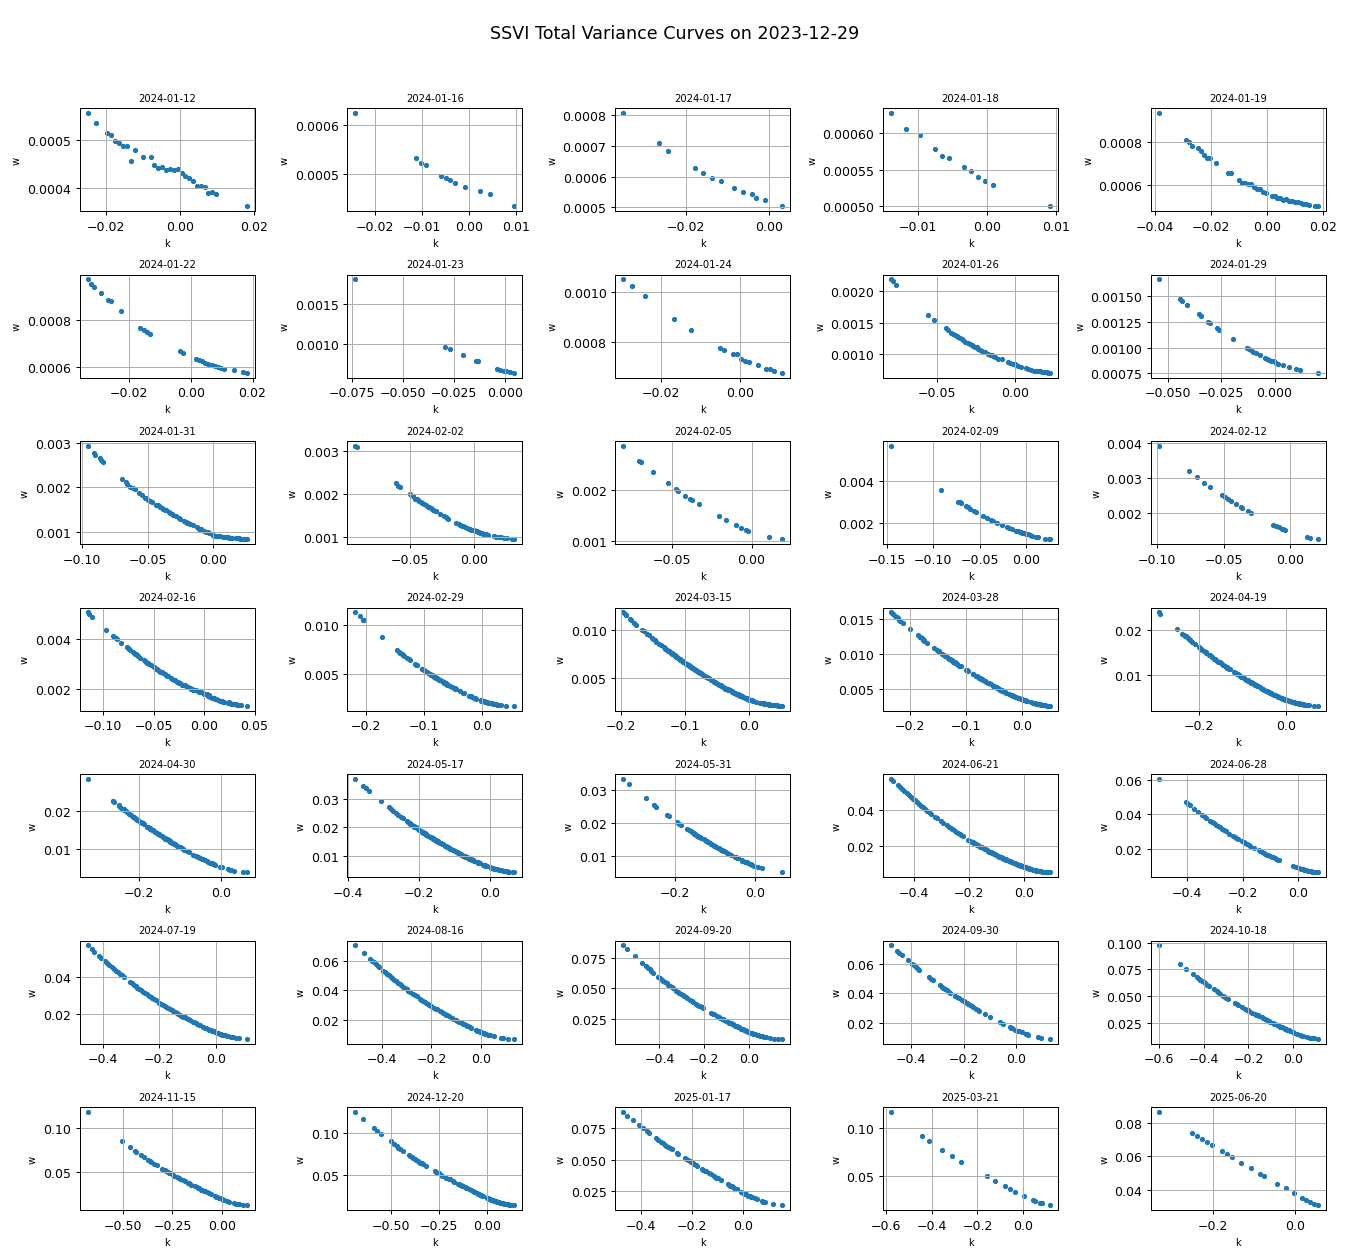

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import math

# Load data
df = pd.read_csv("spx_thetaDec2023.csv", header=0, index_col=0)
df = df.set_index(["quote_date"])
df_2023_12_29 = df.loc["2023-12-29"]

# Unique expiries
expiries = df_2023_12_29["expire_date"].unique()

ncols = 5
nrows = math.ceil(len(expiries) / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 2*nrows))
axes = axes.flatten()

for idx, e in enumerate(expiries):
    fit = df_2023_12_29[df_2023_12_29["expire_date"] == e]
    w = fit["T"] * fit["iv"]**2
    k = fit["log_moneyness"]

    axes[idx].scatter(k, w, s=10)
    axes[idx].set_title(str(e), fontsize=8)
    axes[idx].set_xlabel("k", fontsize=8)
    axes[idx].set_ylabel("w", fontsize=8)
    axes[idx].grid(True)

# Hide any unused axes
for ax in axes[len(expiries):]:
    ax.axis("off")

fig.suptitle("SSVI Total Variance Curves on 2023-12-29", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for title
plt.show()

<IPython.core.display.Javascript object>


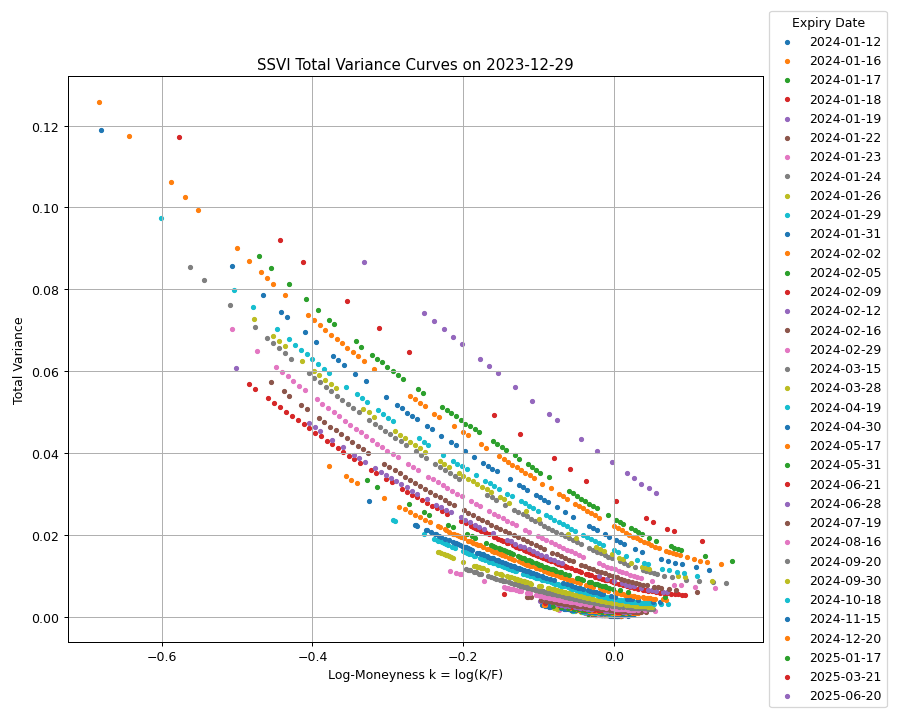

In [23]:
fig, ax = plt.subplots(figsize=(10, 8))

for e in expiries:
    fit = df_2023_12_29[df_2023_12_29["expire_date"] == e]
    w = fit["T"] * fit["iv"]**2
    k = fit["log_moneyness"]
    ax.scatter(k, w, label=str(e), s=10)

ax.set_xlabel("Log-Moneyness k = log(K/F)")
ax.set_ylabel("Total Variance")
ax.set_title("SSVI Total Variance Curves on 2023-12-29")
ax.grid(True)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Expiry Date")

plt.tight_layout()
plt.show()

In [24]:
result_ssvi, result_ssvi_jw, result_ssvi_raw = fit_ssvi_all(df, fi_func=fi_power_law_modified, loss_func = ssvi_loss)

Fitting successfull on quote date 2023-12-01: Train MSE Loss 11.06
Fitting successfull on quote date 2023-12-04: Train MSE Loss 10.99
Fitting successfull on quote date 2023-12-05: Train MSE Loss 11.66
Fitting successfull on quote date 2023-12-06: Train MSE Loss 10.93
Fitting successfull on quote date 2023-12-07: Train MSE Loss 10.52
Fitting successfull on quote date 2023-12-08: Train MSE Loss 11.92
Fitting successfull on quote date 2023-12-11: Train MSE Loss 12.03
Fitting successfull on quote date 2023-12-12: Train MSE Loss 11.00
Fitting successfull on quote date 2023-12-13: Train MSE Loss 10.08
Fitting successfull on quote date 2023-12-14: Train MSE Loss 10.78
Fitting successfull on quote date 2023-12-15: Train MSE Loss 10.14
Fitting successfull on quote date 2023-12-18: Train MSE Loss 11.86
Fitting successfull on quote date 2023-12-19: Train MSE Loss 16.05
Fitting successfull on quote date 2023-12-20: Train MSE Loss 9.06
Fitting successfull on quote date 2023-12-21: Train MSE Loss 10

In [25]:
result_ssvi_vega, result_ssvi_jw_vega, result_ssvi_raw_vega = fit_ssvi_all(df, fi_func=fi_power_law_modified, loss_func = ssvi_loss, weighting = vega_weights)

Fitting successfull on quote date 2023-12-01: Train MSE Loss 9.85
Fitting successfull on quote date 2023-12-04: Train MSE Loss 11.01
Fitting successfull on quote date 2023-12-05: Train MSE Loss 11.15
Fitting successfull on quote date 2023-12-06: Train MSE Loss 9.97
Fitting successfull on quote date 2023-12-07: Train MSE Loss 9.35
Fitting successfull on quote date 2023-12-08: Train MSE Loss 11.09
Fitting successfull on quote date 2023-12-11: Train MSE Loss 10.98
Fitting successfull on quote date 2023-12-12: Train MSE Loss 9.94
Fitting successfull on quote date 2023-12-13: Train MSE Loss 9.22
Fitting successfull on quote date 2023-12-14: Train MSE Loss 9.45
Fitting successfull on quote date 2023-12-15: Train MSE Loss 9.29
Fitting successfull on quote date 2023-12-18: Train MSE Loss 10.96
Fitting successfull on quote date 2023-12-19: Train MSE Loss 16.95
Fitting successfull on quote date 2023-12-20: Train MSE Loss 7.64
Fitting successfull on quote date 2023-12-21: Train MSE Loss 9.08
Fitt

In [26]:
result_ssvi_vega, result_ssvi_jw_inv_vega, result_ssvi_raw_inv_vega = fit_ssvi_all(df, fi_func=fi_power_law_modified, loss_func = ssvi_loss, weighting = inverse_vega_weights)

Fitting successfull on quote date 2023-12-01: Train MSE Loss 11.26
Fitting successfull on quote date 2023-12-04: Train MSE Loss 10.07
Fitting successfull on quote date 2023-12-05: Train MSE Loss 10.99
Fitting successfull on quote date 2023-12-06: Train MSE Loss 10.82
Fitting successfull on quote date 2023-12-07: Train MSE Loss 9.91
Fitting successfull on quote date 2023-12-08: Train MSE Loss 11.15
Fitting successfull on quote date 2023-12-11: Train MSE Loss 11.66
Fitting successfull on quote date 2023-12-12: Train MSE Loss 10.69
Fitting successfull on quote date 2023-12-13: Train MSE Loss 9.01
Fitting successfull on quote date 2023-12-14: Train MSE Loss 11.55
Fitting successfull on quote date 2023-12-15: Train MSE Loss 9.44
Fitting successfull on quote date 2023-12-18: Train MSE Loss 11.16
Fitting successfull on quote date 2023-12-19: Train MSE Loss 14.11
Fitting successfull on quote date 2023-12-20: Train MSE Loss 10.23
Fitting successfull on quote date 2023-12-21: Train MSE Loss 11.5

### Calendar Arbitrage Plot

In [27]:
def svi_raw_total_variance(params, k):
    a, b, rho, m , sigma = params
    w = a + b*(rho*(k-m) + np.sqrt((k-m)**2 + sigma**2))
    return w

def plot_svi_curves(date, data, raw_params, k_min=-0.7, k_max=0.7, k_step=0.01, figsize=(10, 8)):
    day = raw_params.loc[date]
    expiries = day["expire_date"].unique()
    k_range = np.arange(k_min, k_max + k_step, k_step)

    fig, ax = plt.subplots(figsize=figsize)  # Use fig and ax for better control
    
    for expiry in expiries:
        params = day[day["expire_date"] == expiry].iloc[0]  # assuming one row per expiry
        w = svi_raw_total_variance(params[["a", "b", "rho", "m", "sigma"]], k_range)
        ax.plot(k_range, w, label=str(expiry))
        fit = data[(data["expire_date"]==expiry) & (data.index == date)]
        w = fit["T"]*fit["iv"]**2
        k = fit['log_moneyness']
        ax.scatter(k, w, label=None)

    ax.set_xlabel("Log-Moneyness k = log(K/F)")
    ax.set_ylabel("Total Variance")
    ax.set_title(f"SSVI Total Variance Curves on {date}")
    ax.grid(True)

    # Move legend to the right
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Expiry Date")
    #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Expiry Date", fontsize='small', markerscale=0.5)


    plt.tight_layout()
    plt.show()

In [28]:
def plot_svi_curves_iv(date, data, raw_params, padding=0.05, strike_step=1.0, cols=5, figsize=(10, 8)):
    """
    Plot SVI smiles for all expiries on a given date in a grid layout.
    """
    day = raw_params.loc[date]
    expiries = day["expire_date"].unique()
    n_expiries = len(expiries)

    rows = math.ceil(n_expiries / cols)
    fig, axes = plt.subplots(rows, cols, figsize=figsize, squeeze=False)
    axes = axes.flatten()

    for i, expiry in enumerate(expiries):
        params = day[day["expire_date"] == expiry].iloc[0]
        fit = data[(data["expire_date"] == expiry) & (data.index == date)]

        T = fit["T"].iloc[0]
        F = fit["forward"].iloc[0]

        strike_min = fit["strike"].min() * (1 - padding)
        strike_max = fit["strike"].max() * (1 + padding)
        strike_range = np.arange(strike_min, strike_max + strike_step, strike_step)

        k_range = np.log(strike_range / F)
        w_model = svi_raw_total_variance(params[["a", "b", "rho", "m", "sigma"]], k_range)
        iv_model = implied_vol(w_model, T)

        k_data = np.log(fit['strike'] / F)
        iv_data = fit['iv']

        ax = axes[i]
        ax.plot(k_range, iv_model, label="SVI fit", color="blue")
        ax.scatter(k_data, iv_data, label="Market data", color="red", s=10)
        ax.set_title(f"T = {T:.3f}", fontsize=8)
        ax.grid(True)
        ax.tick_params(axis='both', which='major', labelsize=6)

    # Remove empty axes if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

   
    fig.tight_layout()
    plt.show()


In [29]:
dates = result_ssvi.index.unique()
dates

Index(['2023-12-01', '2023-12-04', '2023-12-05', '2023-12-06', '2023-12-07',
       '2023-12-08', '2023-12-11', '2023-12-12', '2023-12-13', '2023-12-14',
       '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20', '2023-12-21',
       '2023-12-22', '2023-12-26', '2023-12-27', '2023-12-28', '2023-12-29'],
      dtype='object', name='quote_date')

<IPython.core.display.Javascript object>


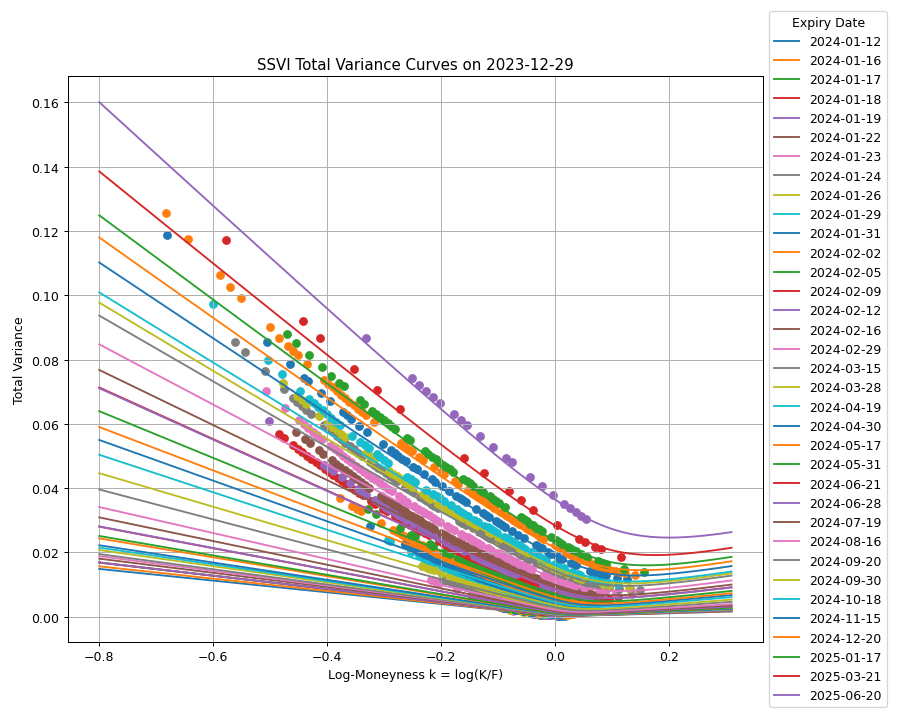

In [30]:
plot_svi_curves(dates[-1], df, result_ssvi_raw, k_min=-0.8, k_max=0.3, figsize=(10, 8))

<IPython.core.display.Javascript object>


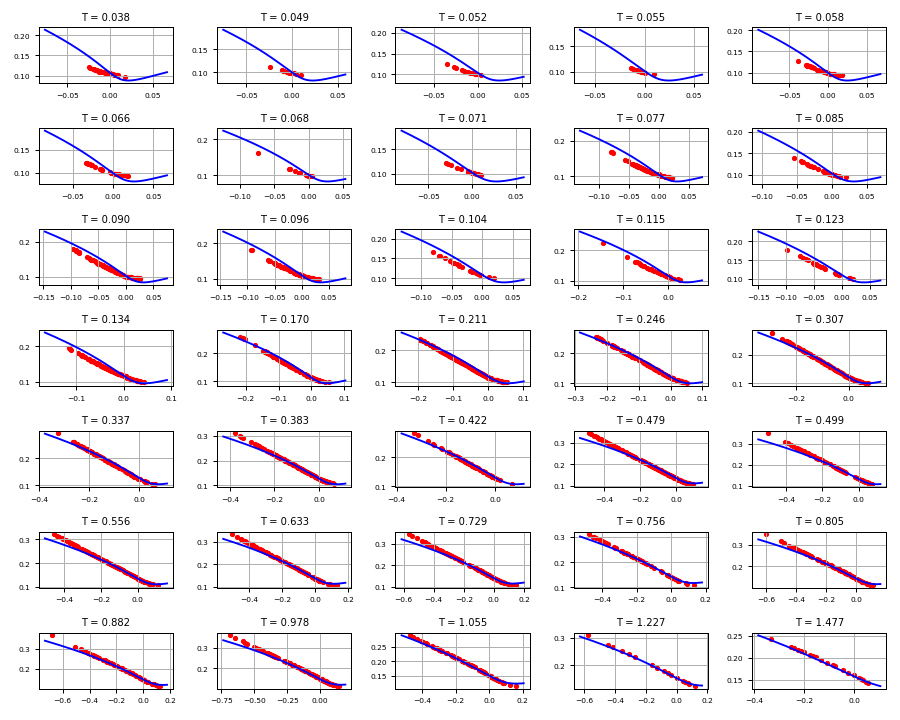

In [31]:
plot_svi_curves_iv(dates[-1], df, result_ssvi_raw)

#### Parameter Stability

In [32]:
result_ssvi_raw.loc["2023-12-29"].describe()

,dte,a,b,rho,m,sigma
count,35.000000,35.000000,35.000000,3.500000e+01,35.000000,35.000000
mean,140.097143,0.002513,0.039204,-5.697936e-01,0.037051,0.053437
std,141.338860,0.003095,0.026752,1.126432e-16,0.025683,0.037041
min,14.000000,0.000148,0.011580,-5.697936e-01,0.010805,0.015584
25%,29.500000,0.000294,0.016292,-5.697936e-01,0.015208,0.021933
50%,76.960000,0.000978,0.029698,-5.697936e-01,0.027778,0.040063
75%,216.960000,0.003680,0.057330,-5.697936e-01,0.054054,0.077959
max,538.960000,0.012321,0.103699,-5.697936e-01,0.100243,0.144577


In [33]:
result_ssvi_jw.loc["2023-12-29"].describe()

,dte,v,psi,p,c,v_tilde
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,140.097143,0.015078,-0.313766,0.864433,0.236900,0.010183
std,141.338860,0.004535,0.001413,0.003893,0.001067,0.003063
min,14.000000,0.009750,-0.314853,0.852209,0.233550,0.006585
25%,29.500000,0.010861,-0.314785,0.862928,0.236488,0.007335
50%,76.960000,0.013733,-0.314467,0.866364,0.237429,0.009274
75%,216.960000,0.018432,-0.313220,0.867240,0.237670,0.012448
max,538.960000,0.024710,-0.309329,0.867427,0.237721,0.016688


### Fit SVI slice by slice

In [34]:
def curve_intersection(curve1, curve2):
    a1_val, b1_val, rho1_val, m1_val, sigma1_val = curve1
    a2_val, b2_val, rho2_val, m2_val, sigma2_val = curve2
    
    k, b1, b2, m1, m2, sigma1, sigma2, alpha, beta = symbols('k b1 b2 m1 m2 sigma1 sigma2 alpha beta')
    
    lhs_inner = 2 * b2 * (alpha + beta * k) * ((k - m2)**2 + sigma2**2)**Rational(1, 2)
    lhs_expr = expand(simplify(lhs_inner))
    
    rhs_inner = b1**2 * ((k - m1)**2 + sigma1**2) - b2**2 * ((k - m2)**2 + sigma2**2) - (alpha + beta * k)**2
    rhs_expr = expand(simplify(rhs_inner))
    # Subtract: LHS - RHS
    diff_expr = expand(simplify(lhs_expr - rhs_expr))
    
    values = {
    b1: b1_val,
    b2: b2_val,
    m1: m1_val,
    m2: m2_val,
    sigma1: sigma1_val,
    sigma2: sigma2_val,
    alpha: a2_val - a1_val + b1_val*rho1_val*m1_val - b2_val*rho2_val*m2_val,
    beta: b2_val*rho2_val - b1_val*rho1_val,
    }
    
    expr_substituted = diff_expr.subs(values)
    roots = solve(expr_substituted, k)
    return roots
    
def crossedness(curve1, curve2): # curve1 corresponds to t1, curve2 to t2 and t2>t1
    if (curve1 is None) or (curve2 is None):
        return 0
    else:
        roots = curve_intersection(curve1, curve2)
        
        real_roots = []
        for root in roots:
            val = root.evalf()
            real_part, imag_part = val.as_real_imag()
            if abs(imag_part) < 1e-10:
                real_roots.append(float(real_part))
       
        real_roots.sort() # increasing order 
        
        valid_roots = []
        for k in real_roots:
            w1 = svi_raw_total_variance(curve1, k)
            w2 = svi_raw_total_variance(curve2, k)
            if abs(w1 - w2) < 1e-6:  # tolerance
                valid_roots.append(k)
        
        if len(valid_roots)>0:
            #print(f"Roots are {roots}")
            #print(f"Real roots are {real_roots}")
            k_tilde = []

            for i in range(len(valid_roots)+1): # 0, 1, 2, 3, 4
                if i==0:
                    k_tilde.append(valid_roots[i]-1)
                elif (i>=1) and (i<=len(valid_roots)-1):
                    k_tilde.append((valid_roots[i]+valid_roots[i-1])/2)
                else:
                    k_tilde.append(valid_roots[i-1]+1)
            
            ci = [max(0, svi_raw_total_variance(curve1, k)-svi_raw_total_variance(curve2, k)) for k in k_tilde]
            #print(ci)
        else:
            ci=[0]
        return max(ci)
    

In [35]:
import numpy as np
from scipy.optimize import brentq

# --- helpers (use your total variance function directly) ---

def _dw_raw(params, k, eps=1e-16):
    """First derivative of raw-SVI total variance w.r.t. k."""
    a, b, rho, m, sigma = params
    discr = np.sqrt((k - m)**2 + sigma**2)
    return b * rho + b * (k - m) / np.where(discr > 0, discr, eps)

def _scan_roots(func, kmin, kmax, n=1000, xtol=1e-10):
    """
    Bracket-and-Brent root finder for a scalar function func(k).
    Returns a sorted list of distinct roots in [kmin, kmax].
    """
    ks = np.linspace(kmin, kmax, n + 1)
    fk = func(ks)
    roots = []
    for i in range(n):
        f1, f2 = fk[i], fk[i + 1]
        if np.sign(f1) == np.sign(f2):
            continue
        a, b = ks[i], ks[i + 1]
        try:
            r = brentq(lambda x: func(x), a, b, xtol=xtol)
            if not roots or abs(r - roots[-1]) > 1e-6:
                roots.append(r)
        except ValueError:
            # rare: function not well behaved in [a,b]; skip
            pass
    return roots

def _default_k_range(curve1, curve2, L=15.0):
    """Wide k-range covering both slices using m ± L*sigma."""
    _, _, _, m1, s1 = curve1
    _, _, _, m2, s2 = curve2
    kmin = min(m1 - L * s1, m2 - L * s2)
    kmax = max(m1 + L * s1, m2 + L * s2)
    # pad a bit
    pad = 1.0
    return kmin - pad, kmax + pad

# --- intersections and crossedness ---

def find_intersections_numeric(curve1, curve2, kmin=-2, kmax=2, n=5000,
                               xtol=1e-10, catch_tangency=True, eps_touch=1e-8):
    """
    Find all real intersections of two raw-SVI slices w1(k)=w2(k) in [kmin,kmax].
    Uses sign-change bracketing + Brent; optionally also detects tangencies.
    """
    if kmin is None or kmax is None:
        kmin, kmax = _default_k_range(curve1, curve2)

    f  = lambda x: svi_raw_total_variance(curve1, x) - svi_raw_total_variance(curve2, x)
    roots = _scan_roots(f, kmin, kmax, n=n, xtol=xtol)

    if catch_tangency:
        # also look for stationary points of f (f' = 0) where |f| ~ 0
        df = lambda x: _dw_raw(curve1, x) - _dw_raw(curve2, x)
        droots = _scan_roots(df, kmin, kmax, n=n, xtol=xtol)
        for r in droots:
            if abs(f(r)) < eps_touch and (not roots or min(abs(r - rr) for rr in roots) > 1e-6):
                roots.append(r)

    return sorted(roots)

def crossedness_numeric(curve1, curve2, kmin=-2, kmax=2):
    """
    Definition 5.1 (Gatheral–Jacquier):
    For intersections k_i, define ẑ points k̃_1 = k_1-1, k̃_i = (k_{i-1}+k_i)/2, k̃_{n+1}=k_n+1.
    Crossedness = max_i max(0, w1(k̃_i) - w2(k̃_i)).
    If no intersections, evaluate at a few probes.
    """
    if (curve1 is None) or (curve2 is None):
        return 0.0

    if kmin is None or kmax is None:
        kmin, kmax = _default_k_range(curve1, curve2)

    roots = find_intersections_numeric(curve1, curve2, kmin, kmax)

    if not roots:
        # no crossings: check representative probes
        #print("No crossings")
        #probes = [kmin, 0.5 * (kmin + kmax), kmax]
        #diffs  = [svi_raw_total_variance(curve1, k) - svi_raw_total_variance(curve2, k) for k in probes]
        return 0

    # Build k̃ points
    ktilde = [roots[0] - 1.0] \
           + [0.5 * (roots[i - 1] + roots[i]) for i in range(1, len(roots))] \
           + [roots[-1] + 1.0]

    ci = [max(0.0, svi_raw_total_variance(curve1, k) - svi_raw_total_variance(curve2, k)) for k in ktilde]
    return max(ci) if ci else 0.0

In [36]:
def svi_g_function(params, k):
    a, b, rho, m, sigma = params
    discr = np.sqrt((k - m)**2 + sigma**2)
    w = a + b * (rho * (k - m) + discr)
    dw = b * rho + b * (k - m) / discr
    d2w = b * sigma**2 / (discr**3)

    g = 1 - k * dw / w + 0.25 * dw**2 * (k**2 / w**2 - 1 / w - 4) + 0.5 * d2w
    return g

def butterfly_arbitrage(params, kmin=-2, kmax=2, n=200):
    ks = np.linspace(kmin, kmax, n)
    gvals = np.array([svi_g_function(params, k) for k in ks])
    return gvals.min()

In [37]:
def svi_raw_prices(params, forward, K, T, pv, k, call): 
    w = svi_raw_total_variance(params, k)
    sigma = implied_vol(w, T)
    prices = black_sholes_price(forward, K, T, sigma, pv, call)
    return prices

def svi_slice_loss(params, slice_data, prev_slice_params, next_slice_params, penalty_weight, crossedness_fun, weighting):
    forward = slice_data['forward'].values
    K = slice_data['strike'].values
    T = slice_data['T'].values 
    pv = slice_data['pv'].values 
    k = slice_data['log_moneyness'].values
    vega = slice_data['vega'].values
    market_prices = slice_data['mid_price'].values
    call = slice_data['call'].values
    model_prices = svi_raw_prices(params, forward, K, T, pv, k, call)
    
    if (
        np.any(np.isnan(model_prices)) or
        np.any(np.isinf(model_prices)) or
        np.any(model_prices < 0)
    ):
        return penalty_weight  # invalid model output
    
    se = (model_prices - market_prices)**2
    weights =  weighting(vega)
    mse = np.sum(se*weights)
    #c1 = crossedness_fun(prev_slice_params, params)
    c2 = crossedness_fun(params, next_slice_params) 
    penaltyC = c2  
    g_min = butterfly_arbitrage(params)
    penaltyB = max(0.0, -g_min)
    
    loss = mse + penalty_weight * (penaltyC + penaltyB)
    return loss

# === Fitting Wrapper ===
def fit_svi_slice_by_slice(df, daily_initial_guess, daily_next_guess,
                           penalty_weight, bounds, constraints,
                           crossedness_fun=crossedness, weighting=equal_weights,
                           loss_func=svi_slice_loss):    
    fitted_params_raw = []
    fitted_params_svi_jw = []
    grouped = df.groupby('quote_date', sort=True)
    
    for quote_date, group in grouped:
        # sort maturities by actual T and make a day-wide k grid
        group = group.sort_values('T')
        kmin_day = float(group['log_moneyness'].min()) - 0.5
        kmax_day = float(group['log_moneyness'].max()) + 0.5
        k_grid   = np.linspace(kmin_day, kmax_day, 121)  # dense enough
        
        total_loss = 0.0        
        prev_slice_params = None
        
        for expire_date, slice_data in group.groupby('expire_date', sort=False):
            initial_guess = daily_initial_guess.loc[(quote_date, expire_date)].values

            # keep next_slice_params (for your loss), even if not used by constraints
            next_slice_params = daily_next_guess.loc[(quote_date, expire_date)].values
            if (next_slice_params is None) or (np.asarray(next_slice_params, dtype=object) == None).any():
                next_slice_params = None
                
            print(f"Processing {quote_date}, expire date {expire_date}.") 
            
            try:
                # add hard calendar monotonicity vs previous slice on k_grid
                cons = list(constraints) + _build_calendar_constraints(prev_slice_params, k_grid)

                loss_tracker = LossTracker(loss_func)
                result = minimize(
                    fun=loss_tracker,
                    x0=initial_guess,
                    args=(slice_data, prev_slice_params, next_slice_params,
                          penalty_weight, crossedness_fun, weighting),
                    bounds=bounds,
                    constraints=cons,
                    method='SLSQP',
                    options={'maxiter': 500}
                )
                
                dte = slice_data['dte'].values[0]
                T = dte/365.0
                a, b, rho, m , sigma = loss_tracker.best_params
                v, psi, p, c, v_tilde = svi_raw_to_jw(loss_tracker.best_params, T)
                prev_slice_params = loss_tracker.best_params
                loss = loss_tracker.best_loss
                            
                fitted_params_raw.append({
                    'quote_date': quote_date,
                    'expire_date': expire_date,
                    'dte': dte,
                    'a': a,
                    'b': b,
                    'rho': rho,
                    'm': m,
                    'sigma': sigma
                })

                fitted_params_svi_jw.append({
                    'quote_date': quote_date,
                    'expire_date': expire_date,
                    'dte': dte,
                    'v': v,
                    'psi': psi,
                    'p': p,
                    'c': c,
                    'v_tilde': v_tilde
                })
                
                total_loss += loss * len(slice_data)
                print(f"Fitting successfull on quote date {quote_date}, expire date {expire_date}: Train MSE Loss {loss:.2f}")
                print(f"Params are a,b, rho, m, sigma = {a:.4f}, {b:.4f}, {rho:.4f}, {m:.4f}, {sigma:.4f}")
                print(f"Params are v,psi,p,c,v_tilde = {v:.4f}, {psi:.4f}, {p:.4f}, {c:.4f}, {v_tilde:.4f}")
      
            except Exception as e:
                print(f"Fitting failed on quote date {quote_date}, expire date {expire_date}: {e}")
                
        total_loss = total_loss / max(len(group), 1)              
        print(f"Fitting successfull on quote date {quote_date}: Train MSE Loss {total_loss:.2f}")

    result_raw = pd.DataFrame(fitted_params_raw).set_index(['quote_date'])
    result_svi_jw = pd.DataFrame(fitted_params_svi_jw).set_index(['quote_date'])
    return result_raw, result_svi_jw

In [38]:
def raw_positivity_constraint(params):
    a, b, rho, m, sigma = params
    val = a + b * sigma * np.sqrt(1 - rho**2)
    if np.isnan(val) or np.isinf(val):
        return -1e10  # return negative value to indicate violation
    return val

# w_curr(k) - w_prev(k) must be >= 0 elementwise on a grid
def _calendar_vector(params_curr, params_prev, k_grid):
    return np.array([
        svi_raw_total_variance(params_curr, k) - svi_raw_total_variance(params_prev, k)
        for k in k_grid
    ])

def _build_calendar_constraints(prev_params, k_grid):
    if prev_params is None:
        return []  # first slice of the day
    return [NonlinearConstraint(lambda p: _calendar_vector(p, prev_params, k_grid),
                                lb=0.0, ub=np.inf)]

### Minimizing price loss - 2023-12-29

#### Equal weights

In [39]:
next_guess = result_ssvi_raw.groupby("quote_date").apply(lambda x: x.shift(-1)).reset_index(level=0,drop=True).replace({np.nan: None})
next_guess["expire_date"] = result_ssvi_raw["expire_date"]

df_2023_12_29 = df.loc["2023-12-29"]
daily_initial_guess_2023_12_29 = result_ssvi_raw.loc["2023-12-29"].reset_index().set_index(["quote_date","expire_date"]).drop(columns=["dte"])
daily_next_guess_2023_12_29 = next_guess.loc["2023-12-29"].reset_index().set_index(["quote_date","expire_date"]).drop(columns=["dte"])

In [40]:
epsilon = 1e-6 
penalty_weight = 1e12

bounds = Bounds(
    [-1,    epsilon,     -1 + epsilon, -np.inf, epsilon],  # Lower bounds
    [np.inf,  np.inf,   1 - epsilon,  np.inf,  np.inf]   # Upper bounds
    )

constraints = [
    NonlinearConstraint(raw_positivity_constraint, 0, np.inf)
    ]

result_slice_raw, result_slice_jw = fit_svi_slice_by_slice(df = df_2023_12_29, 
                                                           daily_initial_guess = daily_initial_guess_2023_12_29, 
                                                           daily_next_guess = daily_next_guess_2023_12_29, 
                                                           penalty_weight = penalty_weight, 
                                                           bounds = bounds, 
                                                           constraints = constraints, 
                                                           crossedness_fun=crossedness_numeric, 
                                                           weighting=equal_weights)
result_slice_raw.to_csv("results/Raw-slice-by-slice_2023-12-29.csv")
result_slice_jw.to_csv("results/JW-slice-by-slice_2023-12-29.csv")

Processing 2023-12-29, expire date 2024-01-12.
Fitting successfull on quote date 2023-12-29, expire date 2024-01-12: Train MSE Loss 10.11
Params are a,b, rho, m, sigma = 0.0001, 0.0116, -0.5698, 0.0085, 0.0157
Params are v,psi,p,c,v_tilde = 0.0107, -0.2992, 0.8977, 0.2460, 0.0077
Processing 2023-12-29, expire date 2024-01-16.
Fitting successfull on quote date 2023-12-29, expire date 2024-01-16: Train MSE Loss 2.89
Params are a,b, rho, m, sigma = 0.0002, 0.0121, -0.5911, 0.0037, 0.0205
Params are v,psi,p,c,v_tilde = 0.0091, -0.2209, 0.9145, 0.2350, 0.0075
Processing 2023-12-29, expire date 2024-01-17.
Fitting successfull on quote date 2023-12-29, expire date 2024-01-17: Train MSE Loss 25.91
Params are a,b, rho, m, sigma = 0.0002, 0.0131, -0.5698, 0.0122, 0.0176
Params are v,psi,p,c,v_tilde = 0.0108, -0.3148, 0.8674, 0.2377, 0.0073
Processing 2023-12-29, expire date 2024-01-18.
Fitting successfull on quote date 2023-12-29, expire date 2024-01-18: Train MSE Loss 10.69
Params are a,b, rho,

Fitting successfull on quote date 2023-12-29, expire date 2024-11-15: Train MSE Loss 2.02
Params are a,b, rho, m, sigma = 0.0044, 0.0813, -0.5619, 0.0788, 0.1100
Params are v,psi,p,c,v_tilde = 0.0216, -0.3371, 0.9201, 0.2581, 0.0134
Processing 2023-12-29, expire date 2024-12-20.
Fitting successfull on quote date 2023-12-29, expire date 2024-12-20: Train MSE Loss 3.40
Params are a,b, rho, m, sigma = 0.0060, 0.0838, -0.5836, 0.0842, 0.1153
Params are v,psi,p,c,v_tilde = 0.0226, -0.3306, 0.8923, 0.2346, 0.0142
Processing 2023-12-29, expire date 2025-01-17.
Fitting successfull on quote date 2023-12-29, expire date 2025-01-17: Train MSE Loss 1.55
Params are a,b, rho, m, sigma = 0.0041, 0.0909, -0.5305, 0.1001, 0.1336
Params are v,psi,p,c,v_tilde = 0.0228, -0.3309, 0.8966, 0.2751, 0.0136
Processing 2023-12-29, expire date 2025-03-21.
Fitting successfull on quote date 2023-12-29, expire date 2025-03-21: Train MSE Loss 2.33
Params are a,b, rho, m, sigma = 0.0090, 0.0986, -0.5300, 0.0950, 0.112

<IPython.core.display.Javascript object>


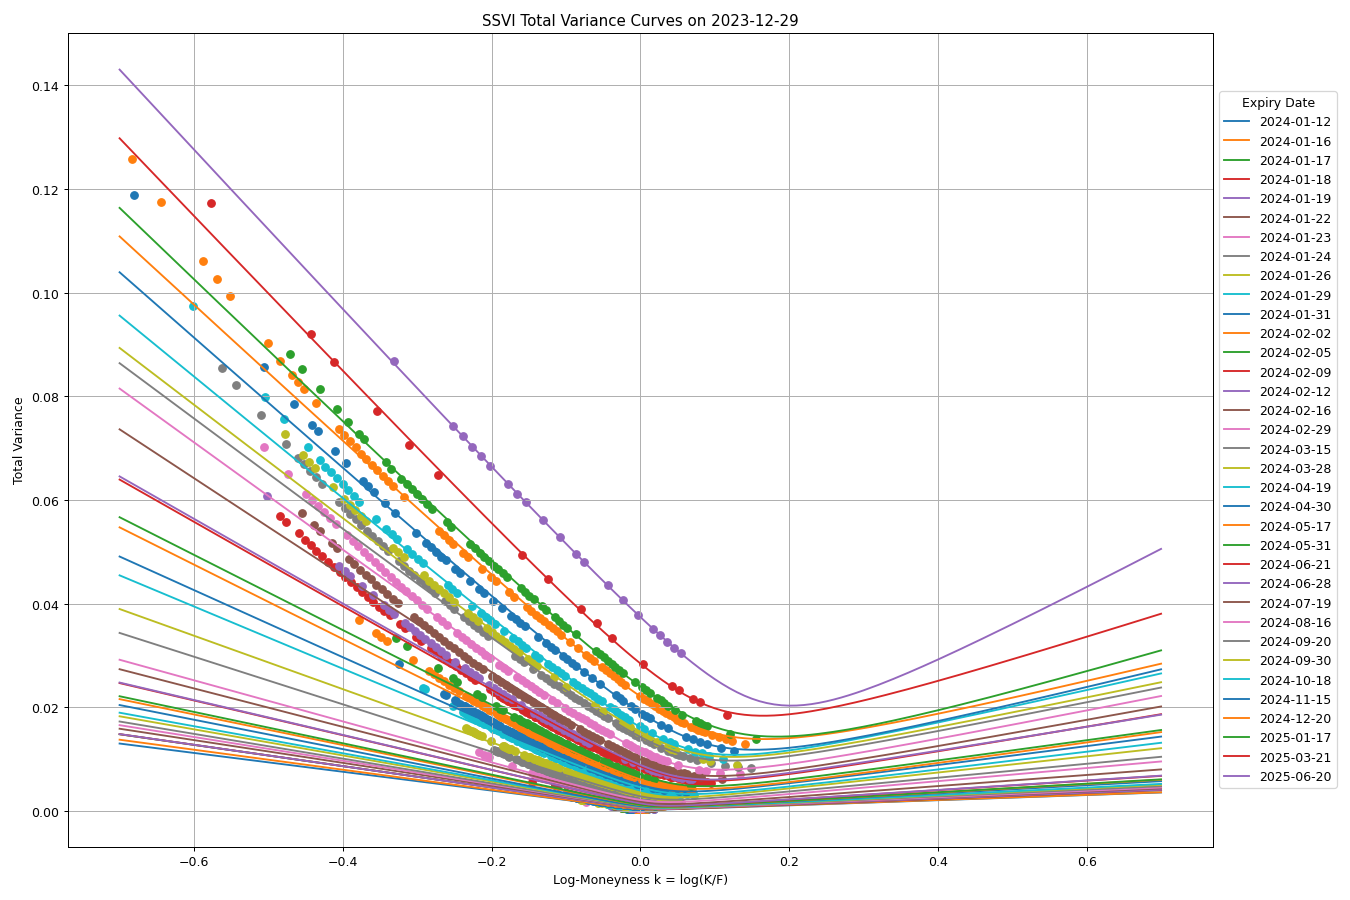

In [41]:
result_2023_12_29 = pd.read_csv("results/Raw-slice-by-slice_2023-12-29.csv", header = 0).set_index(["quote_date"])
plot_svi_curves("2023-12-29", df, result_2023_12_29,  figsize=(15, 10))

<IPython.core.display.Javascript object>


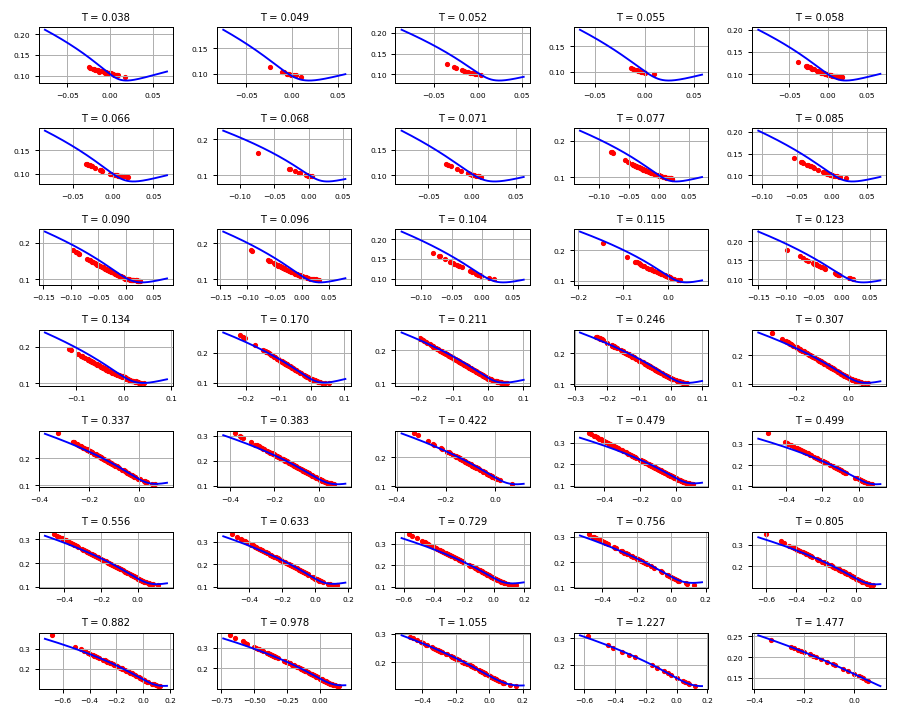

In [42]:
plot_svi_curves_iv("2023-12-29", df, result_2023_12_29)

#### Vega Weights

In [43]:
next_guess = result_ssvi_raw_vega.groupby("quote_date").apply(lambda x: x.shift(-1)).reset_index(level=0,drop=True).replace({np.nan: None})
next_guess["expire_date"] = result_ssvi_raw_vega["expire_date"]

df_2023_12_29 = df.loc["2023-12-29"]
daily_initial_guess_2023_12_29 = result_ssvi_raw_vega.loc["2023-12-29"].reset_index().set_index(["quote_date","expire_date"]).drop(columns=["dte"])
daily_next_guess_2023_12_29 = next_guess.loc["2023-12-29"].reset_index().set_index(["quote_date","expire_date"]).drop(columns=["dte"])

In [44]:
epsilon = 1e-6 
penalty_weight = 1e10

bounds = Bounds(
    [-1,    epsilon,     -1 + epsilon, -np.inf, epsilon],  # Lower bounds
    [np.inf,  np.inf,   1 - epsilon,  np.inf,  np.inf]   # Upper bounds
    )

constraints = [
    NonlinearConstraint(raw_positivity_constraint, 0, np.inf)
    ]

result_slice_raw, result_slice_jw = fit_svi_slice_by_slice(df = df_2023_12_29, 
                                                           daily_initial_guess = daily_initial_guess_2023_12_29, 
                                                           daily_next_guess = daily_next_guess_2023_12_29, 
                                                           penalty_weight = penalty_weight, 
                                                           bounds = bounds, 
                                                           constraints = constraints, 
                                                           crossedness_fun=crossedness_numeric, 
                                                           weighting=vega_weights)

result_slice_raw.to_csv("results/Raw-slice-by-slice-VegaW_2023-12-29.csv")
result_slice_jw.to_csv("results/JW-slice-by-slice-VegaW_2023-12-29.csv")

Processing 2023-12-29, expire date 2024-01-12.
Fitting successfull on quote date 2023-12-29, expire date 2024-01-12: Train MSE Loss 9.57
Params are a,b, rho, m, sigma = 0.0001, 0.0115, -0.5897, 0.0092, 0.0156
Params are v,psi,p,c,v_tilde = 0.0107, -0.3096, 0.8982, 0.2318, 0.0075
Processing 2023-12-29, expire date 2024-01-16.
Fitting successfull on quote date 2023-12-29, expire date 2024-01-16: Train MSE Loss 8.19
Params are a,b, rho, m, sigma = 0.0002, 0.0129, -0.5920, 0.0080, 0.0191
Params are v,psi,p,c,v_tilde = 0.0098, -0.2873, 0.9344, 0.2394, 0.0072
Processing 2023-12-29, expire date 2024-01-17.
Fitting successfull on quote date 2023-12-29, expire date 2024-01-17: Train MSE Loss 8.75
Params are a,b, rho, m, sigma = 0.0001, 0.0130, -0.5897, 0.0126, 0.0176
Params are v,psi,p,c,v_tilde = 0.0088, -0.3541, 0.9618, 0.2482, 0.0052
Processing 2023-12-29, expire date 2024-01-18.
Fitting successfull on quote date 2023-12-29, expire date 2024-01-18: Train MSE Loss 10.59
Params are a,b, rho, m

Fitting successfull on quote date 2023-12-29, expire date 2024-11-15: Train MSE Loss 0.64
Params are a,b, rho, m, sigma = 0.0037, 0.0797, -0.5701, 0.0834, 0.1186
Params are v,psi,p,c,v_tilde = 0.0216, -0.3304, 0.9058, 0.2480, 0.0130
Processing 2023-12-29, expire date 2024-12-20.
Fitting successfull on quote date 2023-12-29, expire date 2024-12-20: Train MSE Loss 1.97
Params are a,b, rho, m, sigma = 0.0069, 0.0830, -0.5830, 0.0840, 0.1053
Params are v,psi,p,c,v_tilde = 0.0226, -0.3369, 0.8839, 0.2329, 0.0143
Processing 2023-12-29, expire date 2025-01-17.
Fitting successfull on quote date 2023-12-29, expire date 2025-01-17: Train MSE Loss 4.54
Params are a,b, rho, m, sigma = 0.0067, 0.0871, -0.5575, 0.0866, 0.1218
Params are v,psi,p,c,v_tilde = 0.0227, -0.3200, 0.8767, 0.2491, 0.0147
Processing 2023-12-29, expire date 2025-03-21.
Fitting successfull on quote date 2023-12-29, expire date 2025-03-21: Train MSE Loss 0.52
Params are a,b, rho, m, sigma = 0.0062, 0.0967, -0.5303, 0.1150, 0.129

<IPython.core.display.Javascript object>


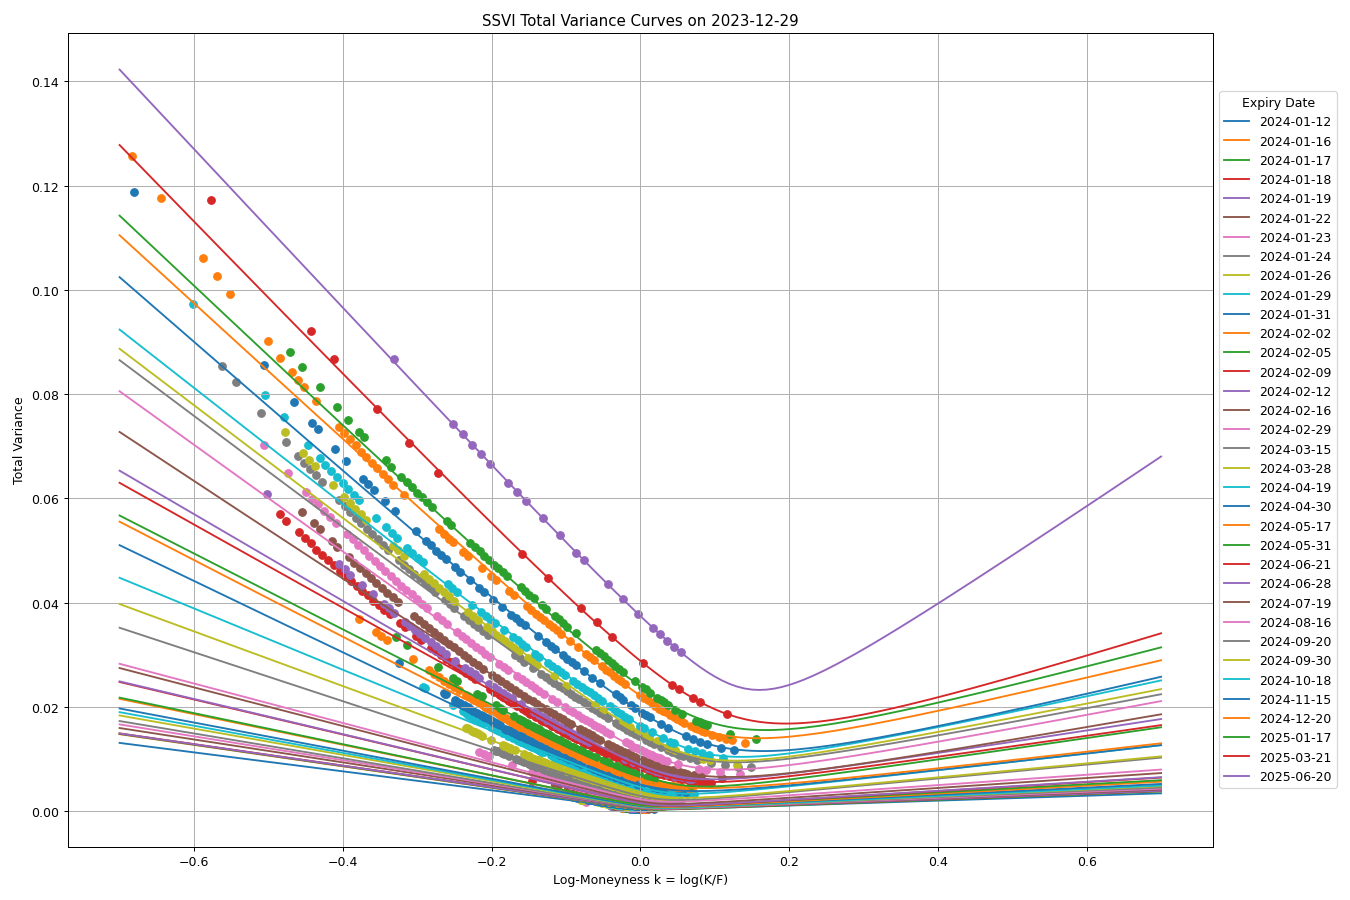

In [45]:
result_2023_12_29_vega = pd.read_csv("results/Raw-slice-by-slice-VegaW_2023-12-29.csv", header = 0).set_index(["quote_date"])
plot_svi_curves("2023-12-29", df, result_2023_12_29_vega,  figsize=(15, 10))

<IPython.core.display.Javascript object>


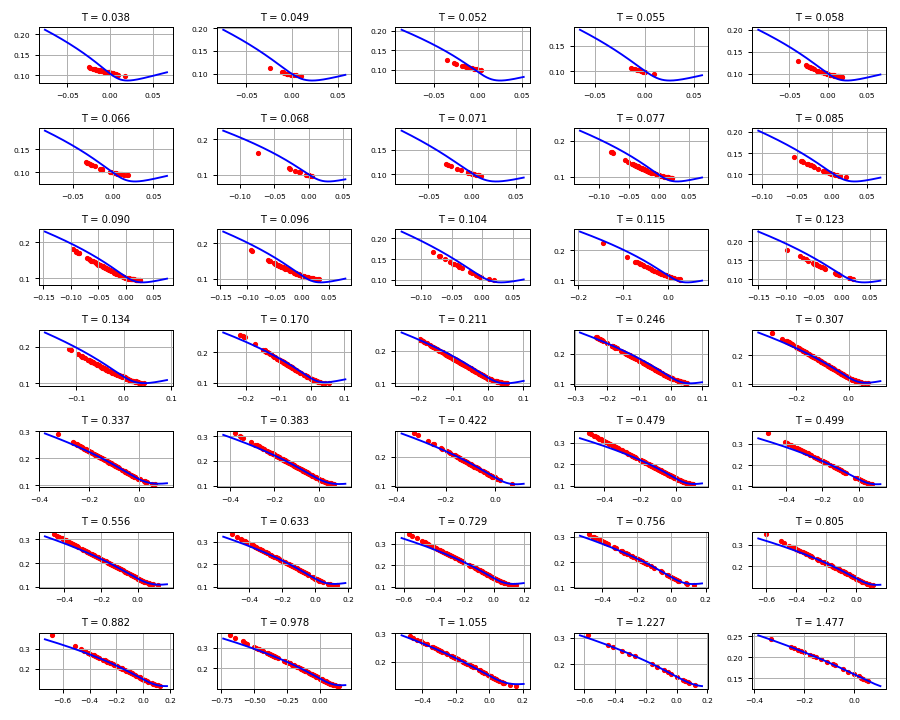

In [46]:
plot_svi_curves_iv("2023-12-29", df, result_2023_12_29_vega)

#### Inverse Vega Weights

In [47]:
next_guess = result_ssvi_raw_inv_vega.groupby("quote_date").apply(lambda x: x.shift(-1)).reset_index(level=0,drop=True).replace({np.nan: None})
next_guess["expire_date"] = result_ssvi_raw_inv_vega["expire_date"]

df_2023_12_29 = df.loc["2023-12-29"]
daily_initial_guess_2023_12_29 = result_ssvi_raw_inv_vega.loc["2023-12-29"].reset_index().set_index(["quote_date","expire_date"]).drop(columns=["dte"])
daily_next_guess_2023_12_29 = next_guess.loc["2023-12-29"].reset_index().set_index(["quote_date","expire_date"]).drop(columns=["dte"])

In [48]:
epsilon = 1e-6 
penalty_weight = 1e10

bounds = Bounds(
    [-1,    epsilon,     -1 + epsilon, -np.inf, epsilon],  # Lower bounds
    [np.inf,  np.inf,   1 - epsilon,  np.inf,  np.inf]   # Upper bounds
    )


constraints = [
    NonlinearConstraint(raw_positivity_constraint, 0, np.inf)
    ]

result_slice_raw, result_slice_jw = fit_svi_slice_by_slice(df = df_2023_12_29, 
                                                           daily_initial_guess = daily_initial_guess_2023_12_29, 
                                                           daily_next_guess = daily_next_guess_2023_12_29, 
                                                           penalty_weight = penalty_weight, 
                                                           bounds = bounds, 
                                                           constraints = constraints, 
                                                           crossedness_fun=crossedness_numeric, 
                                                           weighting=inverse_vega_weights)

result_slice_raw.to_csv("results/Raw-slice-by-slice-InvVegaW_2023-12-29.csv")
result_slice_jw.to_csv("results/JW-slice-by-slice-InvVegaW_2023-12-29.csv")

Processing 2023-12-29, expire date 2024-01-12.
Fitting successfull on quote date 2023-12-29, expire date 2024-01-12: Train MSE Loss 9.71
Params are a,b, rho, m, sigma = 0.0002, 0.0121, -0.5335, 0.0061, 0.0157
Params are v,psi,p,c,v_tilde = 0.0107, -0.2670, 0.9142, 0.2781, 0.0085
Processing 2023-12-29, expire date 2024-01-16.
Fitting successfull on quote date 2023-12-29, expire date 2024-01-16: Train MSE Loss 9.46
Params are a,b, rho, m, sigma = 0.0002, 0.0132, -0.5300, 0.0072, 0.0173
Params are v,psi,p,c,v_tilde = 0.0098, -0.2751, 0.9202, 0.2826, 0.0077
Processing 2023-12-29, expire date 2024-01-17.
Fitting successfull on quote date 2023-12-29, expire date 2024-01-17: Train MSE Loss 28.06
Params are a,b, rho, m, sigma = 0.0002, 0.0135, -0.5335, 0.0111, 0.0176
Params are v,psi,p,c,v_tilde = 0.0108, -0.3041, 0.8741, 0.2659, 0.0077
Processing 2023-12-29, expire date 2024-01-18.
Fitting successfull on quote date 2023-12-29, expire date 2024-01-18: Train MSE Loss 10.58
Params are a,b, rho, 

Fitting successfull on quote date 2023-12-29, expire date 2024-11-15: Train MSE Loss 6.66
Params are a,b, rho, m, sigma = 0.0051, 0.0836, -0.5241, 0.0657, 0.1149
Params are v,psi,p,c,v_tilde = 0.0216, -0.3088, 0.9221, 0.2879, 0.0151
Processing 2023-12-29, expire date 2024-12-20.
Fitting successfull on quote date 2023-12-29, expire date 2024-12-20: Train MSE Loss 12.24
Params are a,b, rho, m, sigma = 0.0082, 0.0863, -0.5278, 0.0763, 0.1000
Params are v,psi,p,c,v_tilde = 0.0230, -0.3261, 0.8785, 0.2715, 0.0159
Processing 2023-12-29, expire date 2025-01-17.
Fitting successfull on quote date 2023-12-29, expire date 2025-01-17: Train MSE Loss 3.42
Params are a,b, rho, m, sigma = 0.0074, 0.0907, -0.4934, 0.0893, 0.1064
Params are v,psi,p,c,v_tilde = 0.0227, -0.3326, 0.8744, 0.2966, 0.0150
Processing 2023-12-29, expire date 2025-03-21.
Fitting successfull on quote date 2023-12-29, expire date 2025-03-21: Train MSE Loss 3.57
Params are a,b, rho, m, sigma = 0.0101, 0.1006, -0.4864, 0.0937, 0.10

<IPython.core.display.Javascript object>


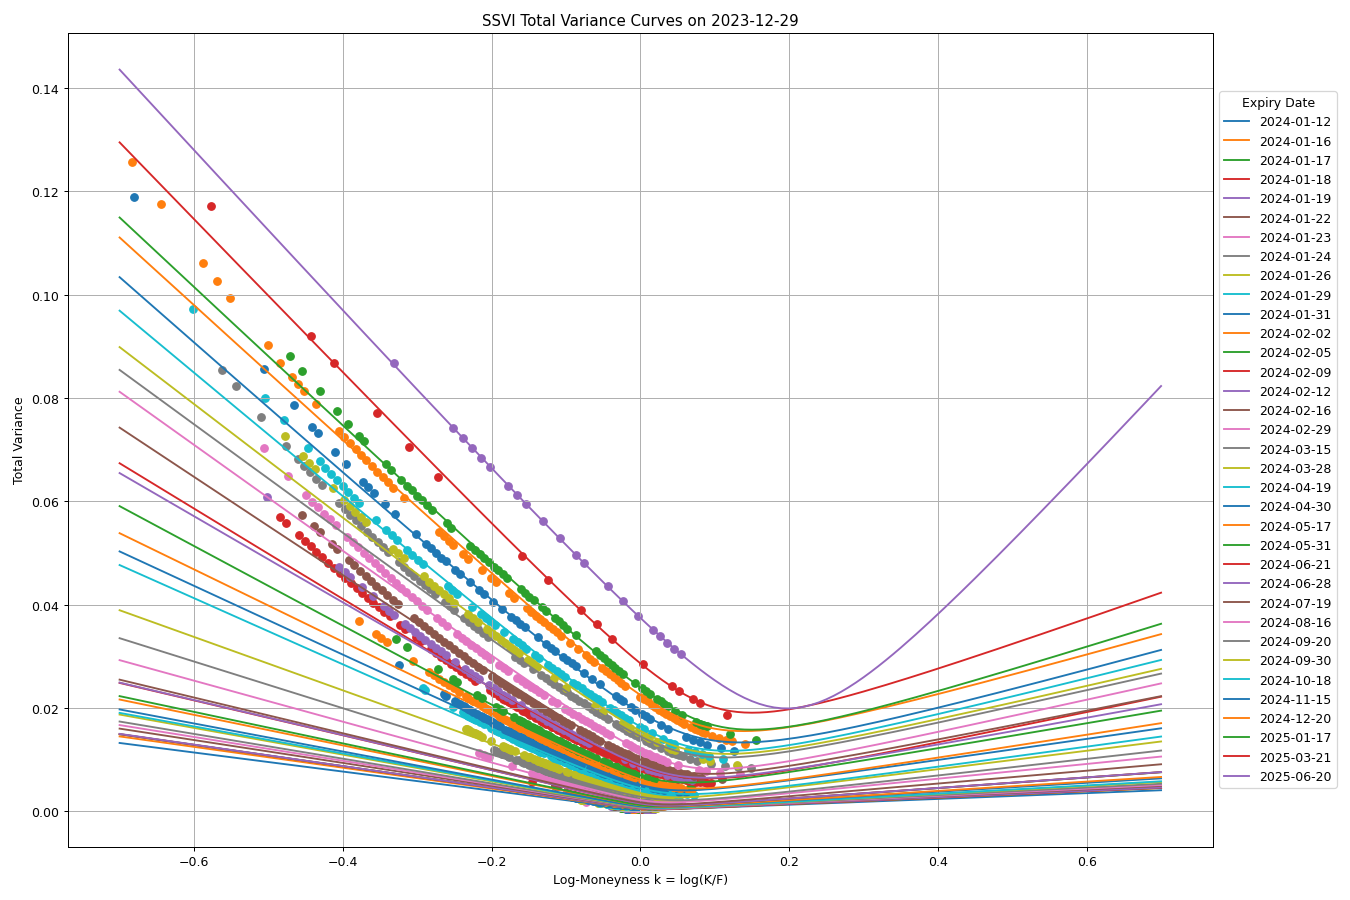

In [49]:
result_2023_12_29_vegaW = pd.read_csv("results/Raw-slice-by-slice-InvVegaW_2023-12-29.csv", header = 0).set_index(["quote_date"])
plot_svi_curves("2023-12-29", df, result_2023_12_29_vegaW,  figsize=(15, 10))

<IPython.core.display.Javascript object>


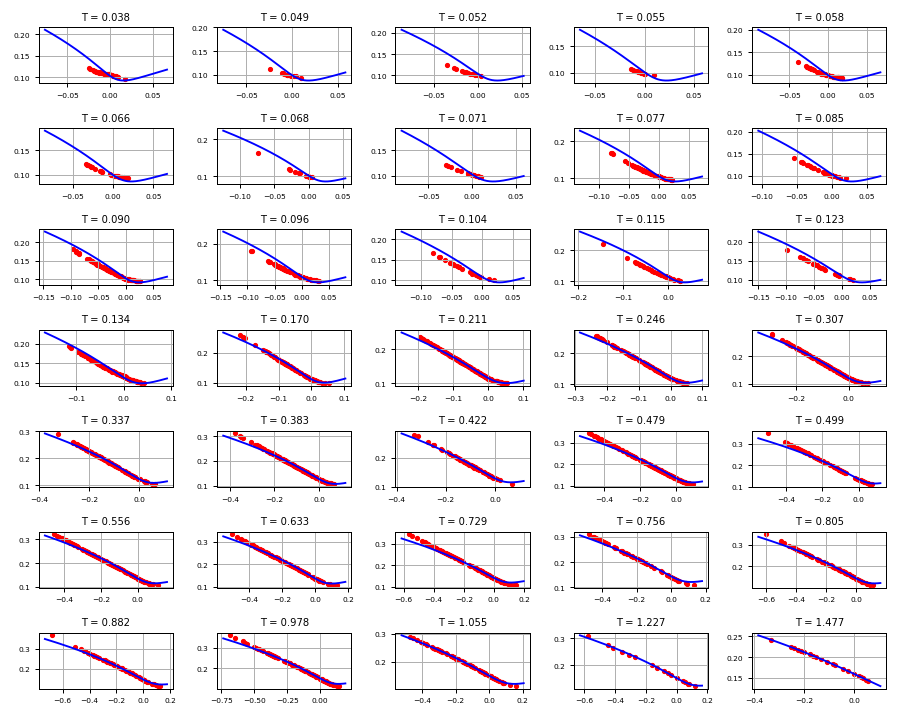

In [50]:
plot_svi_curves_iv("2023-12-29", df, result_2023_12_29_vegaW)

### Evaluate Fits

In [51]:
df["bid-ask-spread"] = np.where(df.call, abs(df.c_ask-df.c_bid), abs(df.p_ask-df.p_bid))

In [52]:
def evaluate_fit(vol_surface, df):
    market_price = df['mid_price'].values
    model_price = []                                                                    
    for index, row in df.iterrows():
                                                  
        params = vol_surface[vol_surface["expire_date"]==row["expire_date"]][["a", "b", "rho", "m" , "sigma"]]                                                                       
        forward = row['forward']
        K = row['strike']
        T = row['T']
        pv = row['pv']
        k = row['log_moneyness']  
        call = row['call']
        model_price.append(svi_raw_prices(params.values.flatten(), forward, K, T, pv, k, call))
        
    return np.mean((model_price - market_price) ** 2)

### 2023-12-29

In [53]:
initial_guess_ssvi_2023_12_29 = result_ssvi_raw.loc["2023-12-29"]
initial_guess_ssvi_vega_2023_12_29 = result_ssvi_raw_vega.loc["2023-12-29"]
initial_guess_ssvi_inv_vega_2023_12_29 = result_ssvi_raw_inv_vega.loc["2023-12-29"]

df_2023_12_29 = df.loc["2023-12-29"]

result_2023_12_29 = pd.read_csv("results/Raw-slice-by-slice_2023-12-29.csv", header = 0).set_index(["quote_date"])
result_vega_2023_12_29 = pd.read_csv("results/Raw-slice-by-slice-VegaW_2023-12-29.csv", header = 0).set_index(["quote_date"])
result_inv_vega_2023_12_29 = pd.read_csv("results/Raw-slice-by-slice-InvVegaW_2023-12-29.csv", header = 0).set_index(["quote_date"])

#### SSVI Initial Guess

Equal weights:

In [54]:
evaluate_fit(initial_guess_ssvi_2023_12_29, df_2023_12_29)

10.25350180354366

Vega weights:

In [55]:
evaluate_fit(initial_guess_ssvi_vega_2023_12_29, df_2023_12_29)

10.412291347538302

Inverse vega weights:

In [56]:
evaluate_fit(initial_guess_ssvi_inv_vega_2023_12_29, df_2023_12_29)

10.607147911249795

#### Slice by slice SVI with square root SSVI initial guess

Equal weights

In [57]:
evaluate_fit(result_2023_12_29, df_2023_12_29)

6.146010544022773

Vega weights:

In [58]:
evaluate_fit(result_vega_2023_12_29, df_2023_12_29)

6.691723993576983

Inverse vega weights:

In [59]:
evaluate_fit(result_inv_vega_2023_12_29, df_2023_12_29)

6.362796532755459

#### Avrage Bid-Ask Spread:

In [60]:
df_2023_12_29["bid-ask-spread"].mean()**2

0.6368864069522491

### Interpolation and Extrapolation

Steps:

- derive ATM variance theta from optimal params
- interpolate with monotonic interpolation to get interpolated theta (Stineman spline)

- use thetas to compute weights
- report price/strike of option as weighted sum of prices/strikes of options in surrounding slices, which have same moneyness as option we want to price.

In [61]:
df_2023_12_29["log_moneyness"].describe(), df_2023_12_29["dte"].describe()

(count    2053.000000
 mean       -0.096175
 std         0.128611
 min        -0.682933
 25%        -0.156259
 50%        -0.058253
 75%        -0.004098
 max         0.155799
 Name: log_moneyness, dtype: float64,
 count    2053.000000
 mean      148.560546
 std       114.240101
 min        14.000000
 25%        49.000000
 50%       122.960000
 75%       202.960000
 max       538.960000
 Name: dte, dtype: float64)

In [62]:
from scipy.interpolate import PchipInterpolator
import math

def interpolate_pchip(x, y, x_new):
    pchip = PchipInterpolator(x, y, extrapolate=False)  # no extrapolation inside PCHIP
    # Prepare output array
    x_new = np.atleast_1d(x_new)
    y_new = np.empty_like(x_new, dtype=float)

    max_x = x.max()
    min_x = x.min()

    for i, xi in enumerate(x_new):
        if xi < min_x:
            # Below range: clamp to first y
            y_new[i] = y[0]
        elif xi <= max_x:
            # Inside range: interpolate
            y_new[i] = pchip(xi)
        else:
            # Above range: linear extrapolation
            slope = (y[-1] - y[-2]) / (x[-1] - x[-2])
            y_new[i] = y[-1] + slope * (xi - x[-1])
    return y_new

def compute_weights(theta, theta1, theta2): # t1 < t < t2
    alpha = (np.sqrt(theta2) - np.sqrt(theta))/(np.sqrt(theta2) - np.sqrt(theta1))
    return alpha

def bs_undiscounted_price(forward, K, T, sigma, pv, call):
    discounted = black_sholes_price(forward, K, T, sigma, pv, call)
    return discounted/pv

def svi_raw_undiscounted_price(params, forward, K, T, pv, call=True):
    a, b, rho, m, sigma = params
    k = np.log(K/forward)
    w = svi_raw_total_variance(params, k)
    bs_sigma = implied_vol(w, T)  
    price = bs_undiscounted_price(forward, K, T, bs_sigma, pv, call)
    return price

def find_surrounding_maturities(t, vol_maturities):
    idx = np.searchsorted(vol_maturities, t)
    if idx == 0:
        return vol_maturities[0], vol_maturities[0]
    elif idx == len(vol_maturities):
        return vol_maturities[-1], vol_maturities[-1]
    else:
        return vol_maturities[idx - 1], vol_maturities[idx]
    
def find_surrounding_params(t1, t2, df):
    return  df[df["dte"]==t1]["theta_svi"].iloc[0], df[df["dte"]==t2]["theta_svi"].iloc[0], df[df["dte"]==t1]["forward"].iloc[0], df[df["dte"]==t2]["forward"].iloc[0], df[df["dte"]==t1]["pv"].iloc[0], df[df["dte"]==t2]["pv"].iloc[0]

In [63]:
def calculate_model_iv(t, k, vol_surface, dataset): 
    T = t/365
    if t in vol_surface["dte"].unique():
        params = vol_surface[vol_surface["dte"]==t][["a", "b", "rho", "m" , "sigma"]].values[0]
        w = svi_raw_total_variance(params, k)
        model_iv = implied_vol(w, T)  
    else:
        vol_maturities = np.array(vol_surface["dte"])
        unique_dataset = dataset[["T", "dte", "theta_svi", "forward", "pv"]].drop_duplicates(subset=["T"], keep="first")

        t1, t2 = find_surrounding_maturities(t, vol_maturities)
        T1 = t1/365
        T2 = t2/365 
        theta1, theta2, forward1, forward2, pv1, pv2 = find_surrounding_params(t1, t2, dataset)
        theta = interpolate_pchip(unique_dataset["dte"], unique_dataset["theta_svi"], t).item()

        if (t1==vol_maturities[-1]) and (t2==vol_maturities[-1]):
            # extrapolate
            params = vol_surface[vol_surface["dte"]==t2][["a", "b", "rho", "m" , "sigma"]].values[0]
            w_t2 = svi_raw_total_variance(params, k)
            w = w_t2 + theta - theta2
            model_iv = implied_vol(w, T)
            if np.isnan(model_iv) or (model_iv==1e-6) or math.isnan(model_iv):
                print("IV IS NAN or 1e-6")
                print(f"Total variance w = {w}")
                print(f"Moneyness = {k}")
                print(f"Strikes: theta={theta},theta2 = {theta2}")
                print(model_iv)
        else:

            forward = interpolate_pchip(unique_dataset["dte"], unique_dataset["forward"], t).item()
            pv = interpolate_pchip(unique_dataset["dte"], unique_dataset["pv"], t).item()

            K = forward*np.exp(k)
            K1 = forward1*np.exp(k)
            K2 = forward2*np.exp(k) 

            weights = compute_weights(theta, theta1, theta2)
            params1 = vol_surface[vol_surface["dte"]==t1][["a", "b", "rho", "m" , "sigma"]]
            params2 = vol_surface[vol_surface["dte"]==t2][["a", "b", "rho", "m" , "sigma"]]

            C1 = svi_raw_undiscounted_price(params1.values.flatten(), forward1, K1, T1, pv1)
            C2 = svi_raw_undiscounted_price(params2.values.flatten(), forward2, K2, T2, pv2)
            C = pv * K * (weights*(C1/K1) + (1-weights)*(C2/K2))
            model_iv = calculate_implied_vol(forward, K, T, pv, C, True)
        
            if np.isnan(model_iv) or (model_iv==1e-6) or math.isnan(model_iv):
                print("IV IS NAN or 1e-6")
                print(f"Weights = {weights}")
                print(f"Moneyness = {k}")
                print(f"Strikes: K={K}, K1 = {K1}, K2 = {K2}")
                print(f"Maturities: t={t}, t1 = {t1}, t2 = {t2}")
                print(f"C is {C}, C1 is {C1}, C2 is {C2}")
                print(f"C={C}, K={K}, F={forward}, pv={pv}, T={T}, t={t}")
                print(model_iv)    
    return model_iv

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_vol_surface(iv, t_range, k_range, elev=20, azim=45):
    plt.close('all')  # ensure fresh figure (prevents bad camera reuse)

    # Convert the nested dict to 2D array
    Z = np.array([
        [iv[t].get(k, np.nan) for t in t_range]
        for k in k_range
    ])
    Z = np.ma.masked_invalid(Z)
    T, K = np.meshgrid(t_range, k_range)

    # Fixed-size figure
    fig = plt.figure(figsize=(12, 8), dpi=100)
    ax = fig.add_subplot(111, projection='3d')

    # Plot
    surf = ax.plot_surface(T, K, Z, cmap='viridis', edgecolor='none')

    # Labels
    ax.set_xlabel("Time to Maturity (in days)")
    ax.set_ylabel("Moneyness (k =log(K/F))")
    ax.set_zlabel("Implied Volatility")
    ax.set_title("Implied Volatility Surface")

    # Lock axis ranges so zooming/rotation doesn't trigger auto-rescale
    ax.set_xlim(min(t_range), max(t_range))
    ax.set_ylim(min(k_range), max(k_range))
    ax.set_zlim(np.nanmin(Z), np.nanmax(Z))

    # Start from a fixed angle
    ax.view_init(elev=elev, azim=azim)

    fig.colorbar(surf, shrink=0.5, aspect=10)
    plt.show() 

In [65]:
t_range = np.arange(14, 365*2 +1, 15)
k_range = np.arange(-0.7, 0.7 + 0.01, 0.001)

iv = {}
for t in t_range:
    iv[t] = {}
    for k in k_range:
        value = calculate_model_iv(t, k, result_inv_vega_2023_12_29, df_2023_12_29)
        iv[t][k] = value

<IPython.core.display.Javascript object>


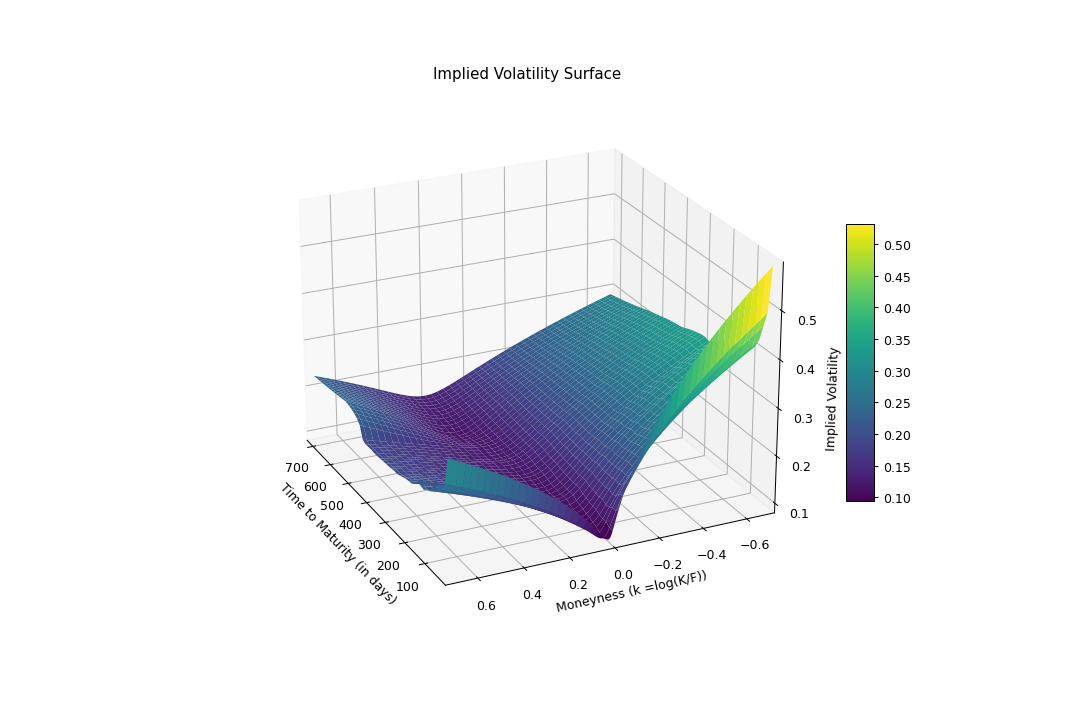

In [66]:
plot_vol_surface(iv, t_range, k_range)